In [ ]:
import torch,os
from pathlib import Path
import numpy as np
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140
import seaborn as sns
from collections import OrderedDict
import pickle,os,json,operator

import utils as utils
import data as data
from importlib import reload
reload(utils);
reload(data);

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

In [2]:
dataset_path = '/scratch/ec2684/research/consistency-lm/training_data/wikitext2-sentencized.json'
vocab_path = '/scratch/ec2684/research/consistency-lm/training_data/wikitext2-sentencized.json.vocab.p'
min_context_length=0
num_eos=1

In [3]:
raw_datasets = json.load(open(dataset_path, 'r'))

In [4]:
for key in raw_datasets:
    raw_datasets[key] = [x.split() for x in raw_datasets[key]]
vocab_file = '.vocab.p' if num_eos == 1 else f'.vocab_{num_eos}.p'

In [5]:
if os.path.exists(dataset_path + vocab_file):
    vocab = pickle.load(open(dataset_path+vocab_file, 'rb'))
else:
    vocab = utils.Dictionary(raw_datasets, include_valid=True, num_eos=num_eos)
    pickle.dump(vocab, open(dataset_path+vocab_file, 'wb'))

In [6]:
tokenized_datasets, eos_stats = utils.tokenize_dataset(raw_datasets, vocab, min_context_length=min_context_length, num_eos=num_eos)
datasets = {name: utils.LMDataset(ds) for name, ds in tokenized_datasets.items()}

stats = {'path': dataset_path,
         'num_train': len(raw_datasets['train']),
         'num_valid': len(raw_datasets['valid']),
         'vocab_size': len(vocab),
         'avg_len': np.mean([len(d) for d in raw_datasets['train']])}

print("Dataset loaded.\n\tTrain size: %d\tValid size: %d\n\t|V|: %d\tmax len: %d\tavg len: %d\n\tTest size (excluded from vocab): %d" % (
        len(raw_datasets['train']),
        len(raw_datasets['valid']),
        len(vocab),
        max(len(x) for x in raw_datasets['train']),
        stats['avg_len'],
        len(raw_datasets['test']),
))

train


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 78274/78274 [00:00<00:00, 120051.32it/s]


valid


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 8464/8464 [00:00<00:00, 171860.76it/s]


test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 9708/9708 [00:00<00:00, 178501.36it/s]


Dataset loaded.
	Train size: 78274	Valid size: 8464
	|V|: 33182	max len: 137	avg len: 24
	Test size (excluded from vocab): 9708


In [7]:
tokenized_train_val = []

for key in tokenized_datasets.keys():
    if key == 'test':
        continue
    for seq in tokenized_datasets['train']:
        tokenized_train_val.append(vocab.decode_idx_seq(seq))

In [8]:
def dummy(doc):
    return doc

vectorizer = CountVectorizer(
        tokenizer=dummy,
        preprocessor=dummy,
    )

In [9]:
docs       = vectorizer.fit_transform(tokenized_train_val)
features   = vectorizer.get_feature_names_out()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


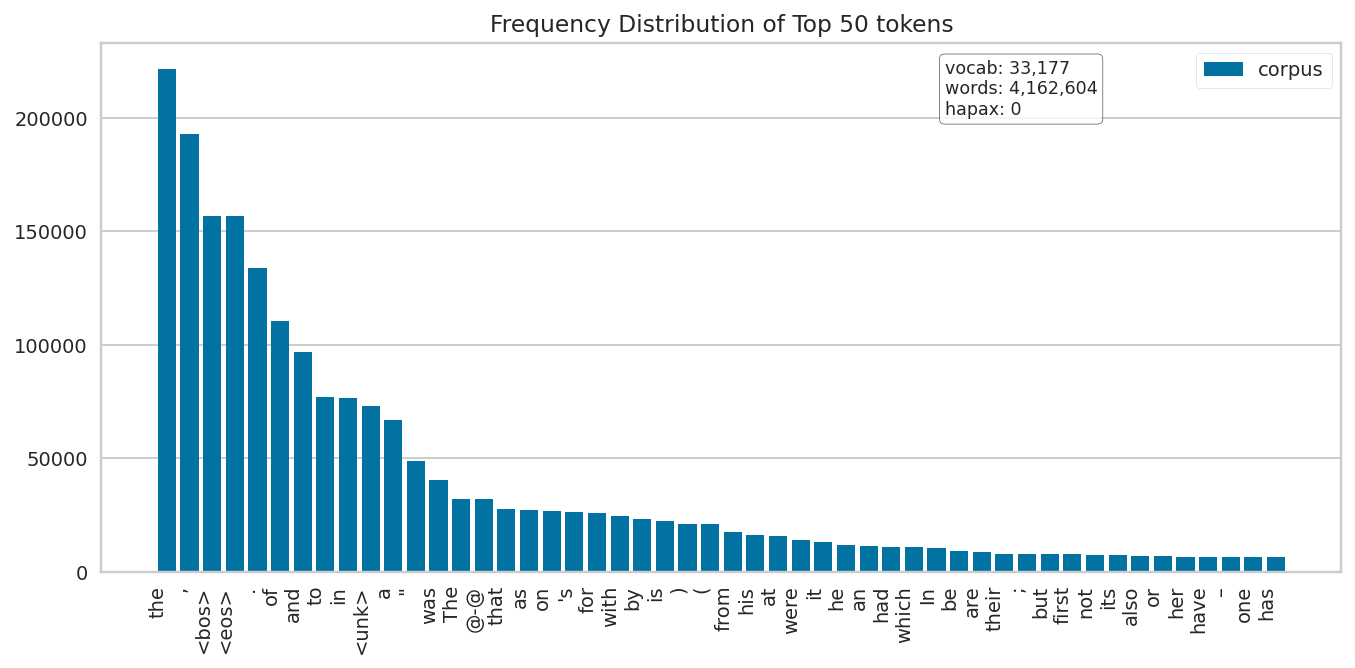

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [12]:
visualizer = FreqDistVisualizer(features=features, orient='v', n=50, size=(1600, 700), ax=plt.gca())
visualizer.fit(docs)
visualizer.show()

In [13]:
sorted_tuples = sorted(vocab.counts.items(), key=operator.itemgetter(1), reverse=True)

sorted_dict = OrderedDict()
for k, v in sorted_tuples:
    sorted_dict[k] = v

In [14]:
for key in list(sorted_dict.keys())[:30]:
    print('{:10}: {:>10}'.format(key,sorted_dict[key]))

the       :     122993
,         :     105816
.         :      73585
of        :      60887
and       :      53353
<unk>     :      44210
to        :      42369
in        :      42247
a         :      36852
"         :      26480
was       :      22476
The       :      17929
@-@       :      17615
that      :      15261
as        :      14972
on        :      14773
's        :      14562
for       :      14165
with      :      13450
by        :      12905
is        :      12034
)         :      11549
(         :      11500
from      :       9616
his       :       8829
at        :       8804
were      :       7929
it        :       7115
he        :       6380
an        :       6360


In [15]:
counts = list(sorted_dict.values())

x = range(len(counts))
y = {'wikitext-2':counts}
df = pd.DataFrame(data=y, index=x)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


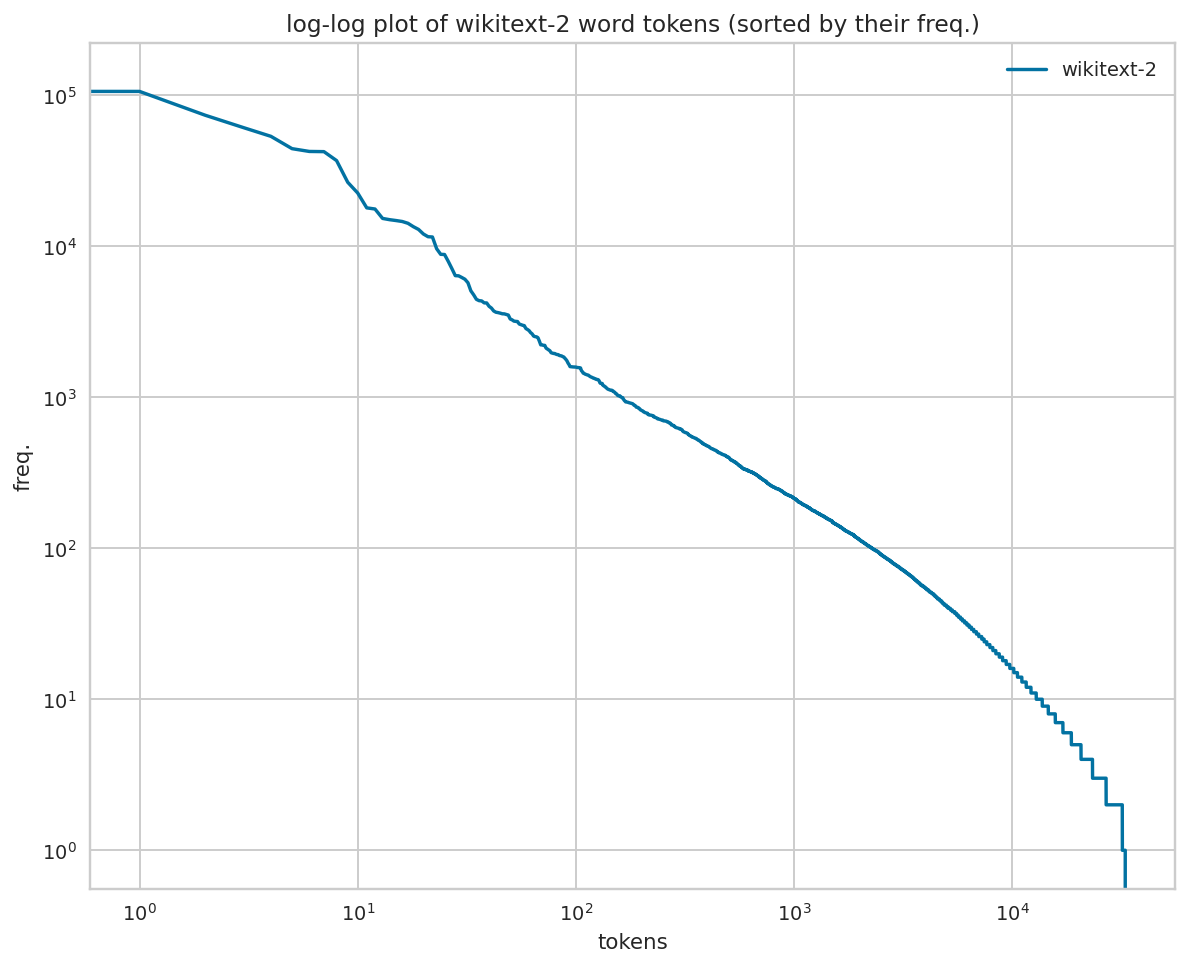

In [16]:
fig = plt.figure(dpi=140)
fig = df.plot(title='log-log plot of wikitext-2 word tokens (sorted by their freq.)',xlabel='tokens',ylabel='freq.',loglog=True,figsize=(10,8),ax=plt.gca())
plt.savefig('wikitext-2_loglog_plot.png')
# plt.show()